In [34]:
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

!mkdir stage1_train stage1_test

!unzip stage1_train.zip -d stage1_train/
!unzip stage1_test.zip -d stage1_test/

In [ ]:
import os
import sys
import numpy as np
import tensorflow as tf
import random
import math
import warnings
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import warnings
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
import visualize

from config import Config
import utils
#import model as modellib
import visualize
#from model import log

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 19
random.seed = seed
np.random.seed = see

In [7]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

In [8]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

train_images = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [9]:
# Resize train images.
print('resize train images... ')
sys.stdout.flush()

#for n, id_ in enumerate(train_ids), total=len(train_ids):
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + "/" + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    train_images[n] = img
    
# Get and resize test images
sizes_test = []
print('resize test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + "/" + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    test_images[n] = img

print('Done!')

resize train images... 


100%|██████████| 670/670 [00:08<00:00, 77.39it/s]

resize test images ... 



100%|██████████| 65/65 [00:00<00:00, 77.61it/s]

Done!


In [25]:
def store_bounding_boxes(img, train_id, mask_id):
    ret, thresh = cv2.threshold(img, 127, 255, 0)
    contours = cv2.findContours(thresh.astype(np.uint8), 1, 2)
    cnt = contours[0]
        
    x, y, w, h = cv2.boundingRect(cnt)    
    
    x = x * (IMG_WIDTH/img.shape[1])
    w = w * (IMG_WIDTH/img.shape[1])
    y = y * (IMG_WIDTH/img.shape[0])
    h = h * (IMG_WIDTH/img.shape[0])
    
    if(x > IMG_WIDTH-1):
        x = IMG_WIDTH-1
    if(y > IMG_HEIGHT-1):
        y = IMG_HEIGHT-1
    if(x+w > IMG_WIDTH-1):
        w = IMG_WIDTH-1 - x
    if(y+h > IMG_HEIGHT-1):
        h = IMG_HEIGHT-1 - y
        
    bbdict = { "train_id": train_id, "mask_id": mask_id,"x": x, "y": y, "w": w, "h": h}
    return bbdict

In [28]:
path_bboxes_csv = "bboxes.csv"
train_masks = {}
bboxes = pd.DataFrame(columns=["train_id", "mask_id","x", "y", "w", "h"])
row_count = 1
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + "/" + id_
    id_files = next(os.walk(path + '/masks/'))[2]
    train_masks[id_] = np.zeros((IMG_WIDTH, IMG_HEIGHT, len(id_files)))
    idx = 0
    for mask_id, mask_file in enumerate(id_files):
        mask_ = imread(path + '/masks/' + mask_file)
        mask_r = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        train_masks[id_][:,:,idx] = mask_r
        idx += 1
        bboxes.loc[row_count] = store_bounding_boxes(mask_, id_, mask_id)
        row_count += 1
bboxes.to_csv(path_bboxes_csv, index=False)

# if not os.path.isfile(path_bboxes_csv):
# else:
#     bboxes = pd.read_csv(path_bboxes_csv)

100%|██████████| 670/670 [03:53<00:00,  2.87it/s]


In [45]:
class DataConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "dsbowl"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = DataConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           dsbowl
NUM_CLASSES                    2
POOL_SIZE               

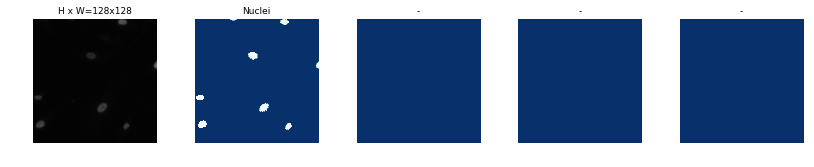

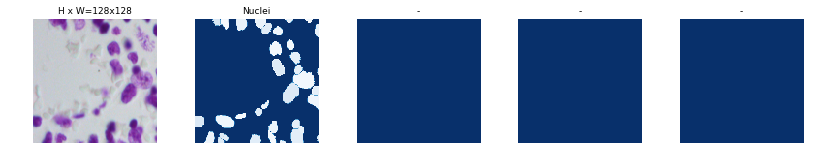

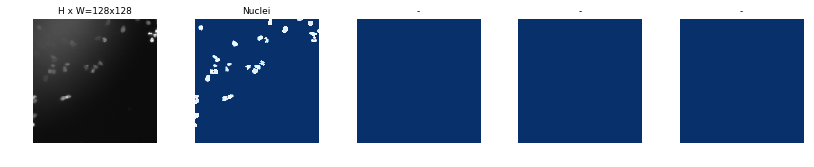

In [41]:
# Load and display random samples
image_idx = np.random.choice(20, 3)
class_names = ['BG', 'Nuclei']

for idx in image_idx:
    image_id = train_ids[idx]
    image = train_images[idx,:,:,:]
    mask = train_masks[image_id]
    class_ids = [1] * mask.shape[2]
    visualize.display_top_masks(image, mask, class_ids, class_names)

In [42]:
class NucleiDataset(utils.Dataset):

    def load_shapes(self, count, height, width):
        # Add classes
        self.add_class("dsbowl", 1, 'Nuclei')

        for i in range(count):            
            self.add_image("dsbowl", image_id=i, path=None,
                           width=width, height=height)

    def load_image(self, image_id):
        return train_images[idx,:,:,:]

#     def image_reference(self, image_id):
#         idx = train_ids[image_id]
#         mask = train_masks[idx]
#         class_ids = np.ones((mask.shape[2]))        
#         return 
#         """Return the mask data of the image."""
#         info = self.image_info[image_id]
#         if info["source"] == "shapes":
#             return info["shapes"]
#         else:
#             super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
#         info = self.image_info[image_id]
#         shapes = info['shapes']
#         count = len(shapes)
#         mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
#         for i, (shape, _, dims) in enumerate(info['shapes']):
#             mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
#                                                 shape, dims, 1)
#         # Handle occlusions
#         occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
#         for i in range(count-2, -1, -1):
#             mask[:, :, i] = mask[:, :, i] * occlusion
#             occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
#         # Map class names to class IDs.
#         class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        idx = train_ids[image_id]
        mask = train_masks[idx]
        class_ids = np.ones((mask.shape[2]))
        return mask.astype(np.bool), class_ids.astype(np.int32)



In [47]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_shapes(100, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_shapes(20, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [48]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

NameError: name 'modellib' is not defined